<h1><center>PHYS-F-303</center></h1>
<h1><center>Partie numérique</center></h1>
<h2><center>Cédric SCHOONEN, Maxime JAMOTTE</center></h2>

# Table des matières

Leçon 06_02
- Question 1
- Question 2

Leçon 06_03
- Question 1
- Question 2

Leçon 06_04
- Question 1
- Question 2

Conclusion

# Leçon 06_02

In [1]:
import time
from matplotlib import pyplot as plt
import numpy as np
import random
%matplotlib inline
from matplotlib import rcParams
rcParams['font.family'] = 'serif'
rcParams['font.size'] = 16
import matplotlib.cm as cm
from matplotlib import animation
from IPython.display import HTML

In [2]:
start_notebook = time.time()

<h2 id="Question21">Question 1</h2>

Le langage Python possède des fonctions précompilées pour générer des nombres distribués de différentes manières, notamment selon une gaussienne ou selon une exponentielle. 

### Distribution exponentielle

Nous écrivons notre distribution exponentielle comme $$ f(x,\lambda) = f(x,1/\beta) = \dfrac{1}{\beta} e^{-x/\beta} $$
Testons la fonction numpy.random.exponential :

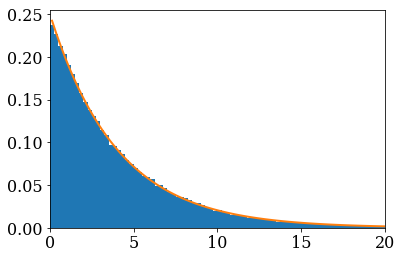

In [3]:
# numpy.random.exponential
lambd = 4
size = 100000
rand_exponential = np.random.exponential(lambd,size)

# Plots
xmax = 20

binwidth=0.25
plt.xlim(0,xmax)
bins=np.arange(0.,xmax+1, binwidth)
plt.hist(rand_exponential,bins,normed=True)

# Compute centers of bins
xc = bins[:-1] + binwidth/2
plt.plot(xc,1/lambd*np.exp(-xc/lambd), lw=2);

Nous retrouvons un résultat identique à celui présenté dans la leçon 06_02. La courbe jaune suit bien l'allure de l'histogramme, la fonction numpy semble donc reproduire nos attentes.

### Distribution gaussienne

La fonction $standard\_normal$est une fonction nous donnant une liste de nombre distribués selon une loi normale.

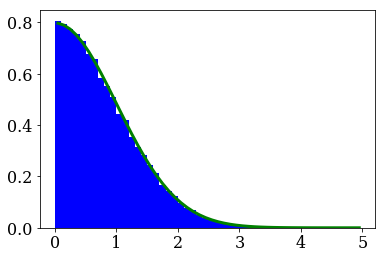

In [4]:
# numpy.random.standard_normal
size = 100000
distrNormal = np.random.standard_normal(size)

# Plots
binwidth=0.1
bins=np.arange(0.,5.1, binwidth)
plt.hist(distrNormal,bins=np.arange(0.,5., binwidth),normed=True,color='blue');

# Compute centers of bins
xc = bins[:-1] + binwidth/2
plt.plot(xc,2*np.exp(-xc**2/2.0)/np.sqrt(2*np.pi),lw=3,color='green');

A nouveau, nous constatons que la loi normale (en vert) épouse bien le profil de l'histogramme.

Ci-dessous, nous présentons une autre façon de générer des nombres suivant une distribution gaussienne pouvant avoir une moyenne différente de 0 et un écart-type différente de 1.

In [5]:
mu = 2
sigma = 0.5
x = np.empty(100000)

for i in range(len(x)):
    x[i] = random.gauss(mu,sigma)

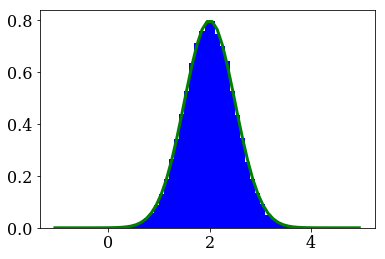

In [6]:
# Plots
binwidth=0.1
bins=np.arange(-1.1,5.1, binwidth)
plt.hist(x,bins=np.arange(0.,5., binwidth),normed=True,color='blue');

# Compute centers of bins
xc = bins[:-1] + binwidth/2
plt.plot(xc,np.exp(-(xc-mu)**2/2.0/sigma**2)/np.sqrt(2*np.pi)/sigma,lw=3,color='green');

<h2 id="Question22">Question 2</h2>

Nous codons ici la méthode dite de "Box-Muller".

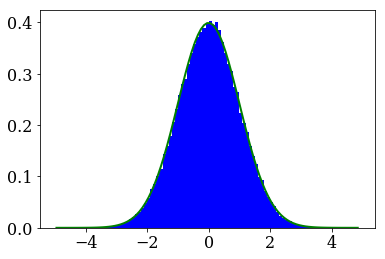

In [7]:
# Box-Muller
N = 100000

u1 = np.random.random_sample(N)
u2 = np.random.random_sample(N)

z0 = np.sqrt(-2*np.log(u1))*np.cos(2*np.pi*u2)
z1 = np.sqrt(-2*np.log(u2))*np.sin(2*np.pi*u1)

# Plots de z0
binwidth=0.1
bins=np.arange(-5,5, binwidth)
plt.hist(z0,bins,normed='true',color='blue');

# Compute centers of bins
xc = bins[:-1] + binwidth/2
plt.plot(xc,np.exp(-xc**2/2.0)/np.sqrt(2*np.pi),lw=2,color='green');

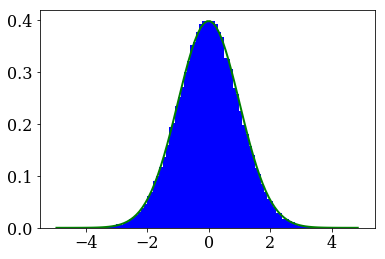

In [8]:
# Plots de z1
binwidth=0.1
bins=np.arange(-5,5, binwidth)
plt.hist(z1,bins,normed='true',color='blue');

# Compute centers of bins
xc = bins[:-1] + binwidth/2
plt.plot(xc,np.exp(-xc**2/2.0)/np.sqrt(2*np.pi),lw=2,color='green');

# Leçon 06_03

## Question 1: dérive

Nous ajoutons ici un terme de dérive à l'équation stochastique initiale:

$$ dx=cdt+\sqrt{2\alpha dt}\cal{N(0,1)} $$

Comme les processus définis par les deux termes du RHS sont indépendants, nous nous attendons à pouvoir faire évoluer la distribution de probabilité en $t=0$ selon un des termes jusqu'au temps voulu, puis selon l'autre. La distribution de probabilité finale doit donc être la distribution obtenue sans la dérive, translatée de $ct$ vers les $x$ positifs. Cela nous donne:

$$ \rho(x,t)=\frac{1}{\sqrt{2\pi\sigma_t^2}}e^{-\frac{(x-\mu)^2}{2\sigma_t^2}} + ct $$

avec $\sigma^2_t = 2\alpha t + \sigma^2$

Remarquons que l'indépendance des deux termes nous permet aussi d'écrire une équation régissant l'évolution de la densité de probabilité, parce que nous pouvons simplement sommer les solutions de deux équations distinctes:

$$ \partial_t \rho_1 = \alpha\ \partial_x^2 \rho_1 $$
$$ \partial_t \rho_2 = c $$

Avec

$$ \rho_1(x,t)=\frac{1}{\sqrt{2\pi\sigma_t^2}}e^{-\frac{(x-\mu)^2}{2\sigma_t^2}} $$
$$ \rho_2(x,t)=ct $$

Ce qui donne une équation pour $\rho = \rho_1 + \rho_2$:

$$ \partial_t \rho = c + \alpha\ \partial_x^2 \rho $$

Il est évident que la solution montrée précédemment est solution de cette équation.
La simulation de ce processus est faite ci-dessous.

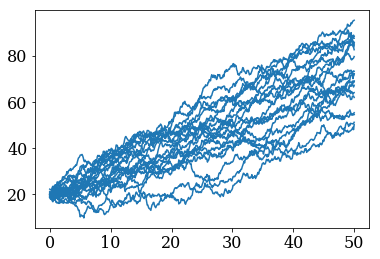

In [9]:
npart=100000
T=50.0
nt=500
dt=T/nt
alpha=2
c = 1

sigma = 1.0
mu = 20.0
x0 = np.random.normal(loc=mu,scale=sigma,size=npart)

t = np.arange(0,T+dt,dt)
x = np.empty([nt+1,npart])

x[0]=x0

for i in range(nt):
    x[i+1]=x[i]+np.sqrt(2*alpha*dt)*np.random.normal(0,1,npart)+c*dt

for i in range(20):
    plt.plot(t,x[:,i],color='C0')

On remarque une translation générale des particules vers les $x$ positifs si $c$ est positif et vers les $x$ négatifs si $c$ est négatif, comme prévu. Comparons les résultats prédits par notre loi aux résultats de la simulation à l'aide d'un histogramme.

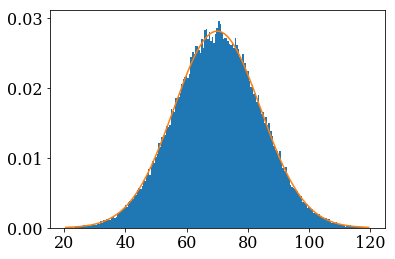

In [10]:
# Generate bins centered around mu+c*T
binwidth=0.5
bins=np.arange(-50+c*T+mu,50+c*T+mu,binwidth)
bins = bins + binwidth/2

# Compute bin centers
bin_centers = bins[:-1]+binwidth/2

# plot a histrogram for verification
plt.hist(x[nt],bins,normed=True);

# The theoretical prediction
sigmat2=2*alpha*T+sigma**2
plt.plot(bin_centers, np.exp(-(bin_centers-c*T-mu)**2/(2.0*sigmat2))/np.sqrt(2*np.pi*sigmat2));

Nous voyons que l'histogramme est en accord avec la prédiction théorique.

## Question 2: friction

Nous ajoutons ici un terme de 'friction' à l'équation stochastique initiale:

$$ dx=-\gamma x dt + \sqrt{2\alpha dt}\cal{N(0,1)} $$

Comme les deux termes ne sont plus indépandants, nous ne pouvons plus appliquer le raisonnement précédant.
Commençons par observer l'effet du terme de friction sur une distribution $\rho(x,t)$ initiale. 

Pour un point individuel, l'évolution de sa position est indépendante des autres points, elle ne dépend que de sa position actuelle et est donnée par une exponentielle:

$$ dx = -\gamma x dt $$
$$ \frac{dx}{dt} = -\gamma x $$
$$ x(t) = x_0\,e^{-\gamma t} $$

Nous connaissons donc la probabilité de trouver une particule dans un intervalle de largeur $dx$ centré en $x$ à partir de sa probabilité d'être à la position de cet intervalle avant l'évolution temporelle, sans oublier que l'intervalle a rétréci au cours de cette évolution:

$$ \rho(x,t)\,dx = \rho(x\,e^{\gamma t},0)\,dx\,e^{\gamma t} $$ 

Nous obtenons donc la densité de probabilité à tout instant:

$$ \rho(x,t) = e^{\gamma t}\rho(x\,e^{\gamma t},0) $$

Ce terme de friction réalise donc une 'homothétie normalisée'.

Connaissant les effets des deux termes sur notre distribution de probabilité gaussienne initiale, nous pouvons étudier leur effet combiné après un temps $t$ quelconque. Cependant, cette tâche n'est pas triviale étant donné que ces effets ne sont pas indépendants. Une solution est d'étudier leurs conséquences après chaque pas de temps $dt$ et les cumuler jusqu'à l'intant $t$ voulu. Nous ferons ensuite tendre $dt$ vers $0$ afin d'éliminer cette composante arbitraire de notre résultat.

L'homothétie causée par le terme de friction sur notre gausienne initiale la déforme de la façon suivante (n'oublions pas que le paramètre $\mu$ est la moyenne des positions et subit donc aussi l'homothétie): 

$$ \frac{1}{\sqrt{2\pi\sigma^2}}e^{-\frac{(x-\mu)^2}{2\sigma^2}} \longmapsto \frac{e^{\gamma dt}}{\sqrt{2\pi\sigma^2}}e^{-\frac{(x\,e^{-\gamma dt}-\mu\,e^{-\gamma dt})^2}{2\sigma^2}} = \frac{1}{\sqrt{2\pi\sigma_{dt}^2}}e^{-\frac{(x-\mu_{dt})^2}{2\sigma_{dt}^2}}$$

Cette action se résume donc par une modification des paramètres de la gaussienne:
$$\sigma \longmapsto \sigma\,e^{-\gamma dt} \qquad  \mu \longmapsto \mu\,e^{-\gamma dt}$$
Nous avons observé précédemment que l'action du terme de diffusion se résume quant à elle par:
$$\sigma^2 \longmapsto \sigma^2 + 2\alpha dt \qquad  \mu \longmapsto \mu$$

L'effet après un pas de temps $dt$ des deux termes agissant de suite se traduit donc par l'évolution ci-dessous. Notons que nous prenons un ordre des termes arbitraire en choisissant de faire agir le terme de friction d'abord, ceci afin de respecter l'ordre utilisé par la simulation. Cependant, ceci n'a pas d'influence dans la limite $dt\rightarrow 0$.

$$ \sigma^2 \longmapsto \sigma^2 e^{-2\gamma dt} + 2\alpha dt $$ 

En répétant l'évolution jusqu'à l'instant $t$ nous obtenons

$$ \sigma^2 \longmapsto \sigma_t^2 = \sigma^2 e^{-2\gamma t} + 2\alpha dt \left[ 1+\dots+e^{-2\gamma(t-dt)} \right]$$
$$ \sigma_t^2 = \sigma^2 e^{-2\gamma t} + 2\alpha dt \frac{1-e^{-2\gamma t}}{1-e^{-2\gamma dt}} $$
$$ \sigma_t^2 = \sigma^2 e^{-2\gamma t} + (1-e^{-2\gamma t}) \frac{2\alpha dt}{2\gamma dt + \mathcal O((dt)^2)} $$

Dans la limite $dt \rightarrow 0$, nous avons donc

$$ \sigma_t^2 = \sigma^2 e^{-2\gamma t} + (1-e^{-2\gamma t}) \frac \alpha\gamma $$

La densité de probabilité est donc donnée par

$$ \rho(x,t) = \frac{1}{\sqrt{2\pi\,\sigma_t^2}}e^{-\frac{(x-\mu_t)^2}{2\sigma_t^2}} $$

Avec

$$ \sigma_t^2 = \sigma^2 e^{-2\gamma t} + (1-e^{-2\gamma t}) \frac \alpha\gamma $$
$$ \mu_t = \mu\, e^{-\gamma t} $$

La distribution d'équilibre pour $t\rightarrow \infty$ est donc une gausienne de moyenne $0$ et d'écart-type égal au ratio $\frac\alpha\gamma$.

Vérifions tout cela avec une simulation.

gamma critique = 50.000


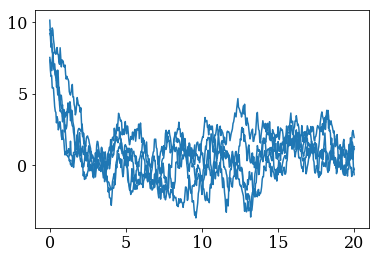

In [11]:
npart=100000
T=20.0
nt=500
dt=T/nt
alpha=2
gamma = 1
print("gamma critique = {:.3f}".format(2.0/dt))

sigma = 1.0
mu = 8.0
x0 = np.random.normal(loc=mu,scale=sigma,size=npart)

t = np.arange(0,T+dt,dt)
x = np.empty([nt+1,npart])

x[0]=x0

for i in range(nt):
    x[i+1]=x[i]+np.sqrt(2*alpha*dt)*np.random.normal(0,1,npart)-gamma*x[i]*dt

for i in range(5):
    plt.plot(t,x[:,i],color='C0')

Nous voyons bien qu'un état d'équilibre est atteint. 

Remarquons que la simulation est instable lorsque des valeurs de $\gamma$ trop grandes sont prises, les positions se mettant à osciller soudainement vers des valeurs de plus en plus grandes. Cela se résouds en prenant des $dt$ plus petits. La raison est due au fait que les sauts $dx = -\gamma dt$ sont tellement grands pour certaines positions que les pas de temps sont trop grands pour les contenir. Cette hypothèse explique bien le caractère ocillatoire de 'l'explosion de valeurs'.

Pour éviter une explosion de ce type, il faudrait que $|dx|<|2x| \iff dt<2/\gamma$, valeur que nous avons affiché comme 'gamma critique'. Le lecteur est libre que vérifier que changer la valeur de gamma un peu au dessus et un peu en dessous de cette valeur critique a un impact très différent sur la stabilité de la simulation.

Comparons maintenant la distribution hors-équilibre avec la prédiction théorique.

time = 0.800


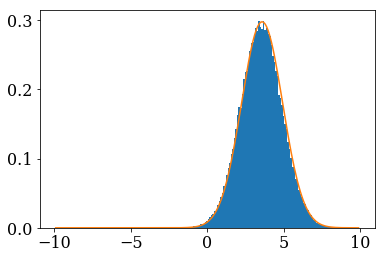

In [12]:
nTT = 20  # index (before equilibrium) for comparison
TT = nTT*dt
print("time = {:.3f}".format(TT))  # to check whether or not we are in the non-equilibrium phase

# Generate bins centered around 0
binwidth=0.1
bins=np.arange(-10,10,binwidth)
bins = bins + binwidth/2

# Compute bin centers
bin_centers = bins[:-1]+binwidth/2

# plot a histrogram for verification
plt.hist(x[nTT],bins,normed=True);

# The theoretical prediction
sigmat2 = sigma**2 * np.exp(-2*gamma*TT) + (1-np.exp(-2*gamma*TT)) * alpha/gamma
plt.plot(bin_centers, np.exp(-(bin_centers-mu*np.exp(-gamma*TT))**2/(2.0*sigmat2))/np.sqrt(2*np.pi*sigmat2));

La prédiction théorique semble en parfaite concordance avec la simulation.

# Leçon  06_04: Modèle d'Ising

## Challenge (vers le milieu du MOOC): Vérification de l'algorithme de Metropolis

Nous recommeçons la vérification du mooc pour plusieurs conditions initiales différentes pour voir si le ratio de spins ups et downs converge bien vers $e^{-\Delta E}$ à chaque fois.

In [13]:
def initial_state_random(nx,ny):
    """ Creates a lattice with random spin orientations
   
    Parameters:
    ----------
    nx   : int
        Discretization points in x
    ny   : int
        Discretization points in y
   
    Returns:
    -------
    r: 2D array of spins
    """
       
    # Uniform random spins between 0 and 1  
    r = np.random.randint(0,2,(nx,ny))
    
    # Where r=0, we assign a negative spin
    r[r==0] =-1

    return r

In [14]:
def initial_state_aligned(nx,ny):
    """ Creates a lattice with aligned spin orientations
   
    Parameters:
    ----------
    nx   : int
        Discretization points in x
    ny   : int
        Discretization points in y
   
    Returns:
    -------
    r: 2D array of spins
    """
    
    r = np.ones([nx,ny])
    
    return r

In [15]:
def energy_at_site(sp,alpha,sigma,ix,iy):
    """ Computes the contribution to the energy for a given spin
    at location ix,iy for a lattice with periodic boundary conditions
   
    Parameters:
    ----------
    sp: numpy array
        array of spins
    alpha  : real
        coupling constant J/(kb*T)
    sigma   : int
        spin at site ix,iy
    ix   : int
        location in x
    iy   : int
        location in y
    
   
    Returns:
    -------
    energy: energy for the given configuration
    """
    
    nx,ny = sp.shape
    
    energy=-alpha*sigma*(sp[(ix-1)%nx,iy]+sp[(ix+1)%nx,iy]+sp[ix,(iy-1)%ny]\
                         +sp[ix,(iy+1)%ny])

    return energy

In [16]:
def metropolis_at_site(sp,alpha,ix,iy):
    """ Flips a dipole at site ix, iy when probability condition is met 
   
    Parameters:
    ----------
    sp: numpy array
        array of spins
    alpha  : real
        coupling constant J/(kb*T)
    ix   : int
        location in x
    iy   : int
        location in y
    """
    sigma=sp[ix,iy]
    energy_before_flip = energy_at_site(sp,alpha,sigma,ix,iy)
    sigma = -sigma
    energy_if_site_flipped = energy_at_site(sp,alpha,sigma,ix,iy)
    
    # Flip the site with Metropolis probability
    # Condition is always satisifed if dE < 0
    if (np.random.random_sample()<np.exp(-(energy_if_site_flipped \
                                               -energy_before_flip))):
        sp[ix,iy]=-sp[ix,iy]

In [17]:
def test_Metropolis(n,NMC):
    """ Execute many times the mooc's test for the metropolis algorithm.
   
    Parameters:
    ----------
    n: number of times the metropolis algorithm will be tested.
    NMC: number of flips to perform for each test.
    
    Returns:
    -------
    probas_theo: vector containing the results for the theoretical probability for the flip
    ratios:      vector containing the computed ratios ups/downs.
    """
    
    nx=10
    ny=10
    alpha = 0.1
    
    probas_theo = np.empty(n)
    ratios = np.empty(n)

    for i in range(n):
        
        # Initial spins at each site, chosen randomly
        sp = initial_state_random(nx,ny)

        energy_0 = energy_at_site(sp,alpha,-1,5,5)
        energy_1 = energy_at_site(sp,alpha, 1,5,5)

        states = np.empty(NMC)
        states[0]=sp[5,5]

        for m in range(0,NMC):
            
            metropolis_at_site(sp,alpha,5,5)
            states[m]=sp[5,5]

            ups = np.extract(states==1, states).size
            downs = NMC - ups
            
        probas_theo[i] = np.exp(energy_0-energy_1)
        ratios[i] = ups/downs
    
    return [probas_theo, ratios]

In [18]:
tests = 6
[probas_theo, ratios] = test_Metropolis(tests,3000)
print(probas_theo)
print(ratios)

[ 0.67032005  1.4918247   0.67032005  1.4918247   0.67032005  1.4918247 ]
[ 0.67973124  1.48138958  0.69014085  1.49169435  0.67037862  1.48344371]


Notons que pour chaque test, les ratios donnés par l'algorithme de Metropolis convergent bien vers la probabilité théorique. Remarquons également que si $\Delta E = 0$, le flip se fera à tous les coups et nous  aurons donc toujours le même résultat pour le ratio, dépendant du nombre de flips effectués (le ratio vaut toujours 1 si le nombre de flips est pair).

## Question 1: Calculer la magnétisation moyenne pour différentes valeurs de $\alpha$ entre 0 et 1 et estimer la valeur de $\alpha$ critique

Nous calculons la magnétisation moyenne comme: $$ \left \langle M \right \rangle = \dfrac{\sum_{k=1}^{N} M_k }{N} $$ avec $M_k = \sum_{i=1}^{b} s_i$ où $N$ est le nombre de tranches simulées et $b$ le nombre de cases dans une tranche dans lesquelles se trouvent les spins que nous sommons.

Commençons par définir les fonctions à utiliser pour observer l'évolution de la magnétisation pour un alpha donné.

In [19]:
def initial_state_aligned(nx,ny):
    """ Creates a lattice with aligned spin orientations
   
    Parameters:
    ----------
    nx   : int
        Discretization points in x
    ny   : int
        Discretization points in y
   
    Returns:
    -------
    r: 2D array of spins
    """
    
    r = np.ones([nx,ny])
    
    return r

In [20]:
def moy_magn(sp): 
    """ Computes the average magnetisation for a given state
   
    Parameters:
    ----------
    sp   : lattice state
    
    Returns:
    -------
    M: average magnetisation for the lattice state sp 
    """
    
    M = sp.sum(axis=(0,1))/(len(sp)*len(sp[0]))
    return M

In [21]:
def moy_ener(sp,alpha): 
    """ Computes the average energy for a given state
   
    Parameters:
    ----------
    sp   : lattice state
    
    Returns:
    -------
    E: average energy for the lattice state sp 
    """
    pairsNorth = np.multiply(sp,np.roll(sp,-1,axis=0)) # pas de boucle -> + efficace à priori
    pairsEast  = np.multiply(sp,np.roll(sp,-1,axis=1))
    pairsSouth = np.multiply(sp,np.roll(sp,1,axis=0))
    pairsWest  = np.multiply(sp,np.roll(sp,1,axis=1))
    E = -alpha * (pairsNorth.sum(axis=(0,1)) + pairsEast.sum(axis=(0,1)) 
                      + pairsSouth.sum(axis=(0,1)) + pairsWest.sum(axis=(0,1)))
    E = E/(len(sp)*len(sp[0]))
           
    return E

In [22]:
def moy_ener_vect(sp,alphas): 
    """ Computes the average energy for a given state
   
    Parameters:
    ----------
    sp   : lattice state
    
    Returns:
    -------
    E: average energies for the lattice state sp for all the alpha's values
    """
    E = np.empty(len(alphas))
    for i in range(len(alphas)):
        pairsNorth = np.multiply(sp,np.roll(sp,-1,axis=0)) # pas de boucle -> + efficace à priori
        pairsEast  = np.multiply(sp,np.roll(sp,-1,axis=1))
        pairsSouth = np.multiply(sp,np.roll(sp,1,axis=0))
        pairsWest  = np.multiply(sp,np.roll(sp,1,axis=1))
        E[i] = -alphas[i] * (pairsNorth.sum(axis=(0,1)) + pairsEast.sum(axis=(0,1)) 
                          + pairsSouth.sum(axis=(0,1)) + pairsWest.sum(axis=(0,1)))
        E[i] = E[i]/(len(sp)*len(sp[0]))
           
    return E

In [23]:
def M_with_time_for_alpha(sp,nx,ny,NMC,step,alpha):
    """ Computes the evolution of the magnetisation and energy with time for a given coupling constant for the Ising model using
    the Metropolis algorithm
   
    Parameters:
    ----------
    sp   : initial lattice state
    nx   : int
        Discretization points in x
    ny   : int
        Discretization points in y
    NMC  : int
        Number of states to create
    step   : Step between each magnetisation computation
    alpha  : real
        coupling constant J/(kb*T)
    Returns:
    -------
    M: magnetisation 
    E: energie 
    """
    
    M = np.empty([int(NMC/step)])
    E = np.empty([int(NMC/step)])
    
    for i in range(int(NMC)):
        #if i%(int(NMC/10)+1)==0:
            #print("loop {:d} of {:d} for alpha = {:.2f}".format(i,NMC,alpha))
        for j in range(0,nx*ny):
            ix=np.random.randint(0,nx)
            iy=np.random.randint(0,ny)
            metropolis_at_site(sp,alpha,ix,iy)
        if i%step==0:
            M[int(i/step)] = moy_magn(sp)
            E[int(i/step)] = moy_ener(sp,alpha)
    return [M,E]

Calculons l'évolution de la magnétisation pour un alpha donné afin de vérifier que le code fonctionne bien.

In [24]:
NMC = 300 
step = 1
nx = 20 
ny = 20
alpha = 0.35

sp = initial_state_aligned(nx,ny)
E_aligned = moy_ener(sp,alpha)

[M,E] = M_with_time_for_alpha(sp,nx,ny,NMC,step,alpha)

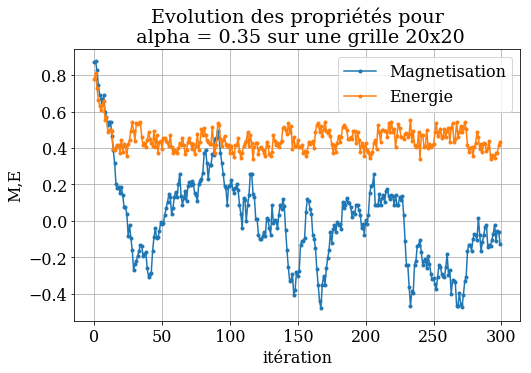

In [25]:
plt.figure(figsize=(8,5));
plt.plot(np.arange(0,len(M)*step,step),M, '.-', label='Magnetisation');
plt.plot(np.arange(0,len(E)*step,step),E/E_aligned, '.-', label='Energie')
plt.title("Evolution des propriétés pour\n alpha = {:.2f} sur une grille {:d}x{:d}".format(alpha,nx,ny));
plt.xlabel('itération');
plt.ylabel('M,E');
plt.legend(loc=1);
plt.grid()
plt.show()

Ce graphique nous permet d'estimer le nombre d'itération nécessaire pour atteindre un équilibre statistique. Nous allons en avoir besoin pour calculer les propriétés (magnétisation et énergie) du sysème à l'équilibre. Pour automatiser ce calcul pour plusieurs valeurs de $\alpha$, il nécessaire de s'assurer que le nombre d'itération attendues pour atteindre l'équilbre majore celui nécessaire pour chaque valeur de $\alpha$. C'est pourquoi nous avons testé plusieurs valeurs de alpha et choisi pour ce graphique une valeur de alpha parmi celles qui met le plus de temps à atteindre l'équilibre pour un état initial de spins alignés. Nous avons répété plusieurs fois l'algorithme pour cette valeur et avons observé que l'équilibre était toujours atteint avant 50 itérations, nous prendrons 100 itérations pour être sûr d'avoir atteint l'équilibre. Notons que pour des valeurs de alpha proche de la transition (vers 0.4), les propriétés du système (magnétisation, énergie) fluctuent beaucoup.

Automatisons maintenant la procédure pour calculer la magnétisation à l'équilibre pour un grand nombre de couplages différents.

In [26]:
def M_equilibrium_for_alphas(sps,nx,ny,NMC,step,alphas,NMC_eq):
    """ Computes averages of physical quantities at equilibrium with different coupling constants for the Ising model using
    the Metropolis algorithm
   
    Parameters:
    ----------
    sps  : Vector containing the initial lattice states
    nx   : int
        Discretization points in x
    ny   : int
        Discretization points in y
    NMC  : int
        Number of states to create
    step   : Step between each magnetisation computation
    alphas : Vector of reals containing the
        coupling constants alpha = J/(kb*T)
    NMC_eq : Number of states to create before reaching the equilibrium
    Returns:
    -------
    Ms     : Vector of magnetisations at equilibrium for each alpha in alphas
    Es     : Vector of energis at equilibrium for each alpha in alphas
    VarEs  : Vector of the variances of the energy at equilibrium for each alpha in alphas
    """
    
    Ms  = np.empty([len(alphas)])
    Es  = np.empty([len(alphas)])
    VarEs = np.empty([len(alphas)])
    
    for i in range(len(alphas)):
        
        print("loop at alpha = {:.3f}".format(alphas[i]))
        spsi = sps[i]
        
        for j in range(NMC_eq):
            
            for k in range(0,nx*ny):
                ix = np.random.randint(0,nx)
                iy = np.random.randint(0,ny)
                metropolis_at_site(spsi,alphas[i],ix,iy)
        
        [M_evol,E_evol] = M_with_time_for_alpha(spsi,nx,ny,NMC-NMC_eq,step,alphas[i])
        Ms[i]  = M_evol.sum()/len(M_evol)
        Es[i]  = E_evol.sum()/len(E_evol)
        VarEs[i] = (E_evol**2).sum()/len(E_evol) - (E_evol.sum()/len(E_evol))**2
    
    return [Ms,Es,VarEs]

Calculons donc la magnétisation d'équilbre pour plusieurs valeurs de $\alpha$.

In [27]:
NMC = 100+500
NMC_eq = 100
step = 1
nx = 20
ny = 20
a = 101
alphas = np.linspace(0,1,a)

sps = np.empty([a,nx,ny])
for i in range(a):
    sps[i] = initial_state_aligned(nx,ny)
    
E_aligned = moy_ener_vect(np.ones((nx,ny)),alphas)

[Ms,Es,VarEs] = M_equilibrium_for_alphas(sps,nx,ny,NMC,step,alphas,NMC_eq)

loop at alpha = 0.000
loop at alpha = 0.010
loop at alpha = 0.020
loop at alpha = 0.030
loop at alpha = 0.040
loop at alpha = 0.050
loop at alpha = 0.060
loop at alpha = 0.070
loop at alpha = 0.080
loop at alpha = 0.090
loop at alpha = 0.100
loop at alpha = 0.110
loop at alpha = 0.120
loop at alpha = 0.130
loop at alpha = 0.140
loop at alpha = 0.150
loop at alpha = 0.160
loop at alpha = 0.170
loop at alpha = 0.180
loop at alpha = 0.190
loop at alpha = 0.200
loop at alpha = 0.210
loop at alpha = 0.220
loop at alpha = 0.230
loop at alpha = 0.240
loop at alpha = 0.250
loop at alpha = 0.260
loop at alpha = 0.270
loop at alpha = 0.280
loop at alpha = 0.290
loop at alpha = 0.300
loop at alpha = 0.310
loop at alpha = 0.320
loop at alpha = 0.330
loop at alpha = 0.340
loop at alpha = 0.350
loop at alpha = 0.360
loop at alpha = 0.370
loop at alpha = 0.380
loop at alpha = 0.390
loop at alpha = 0.400
loop at alpha = 0.410
loop at alpha = 0.420
loop at alpha = 0.430
loop at alpha = 0.440
loop at al

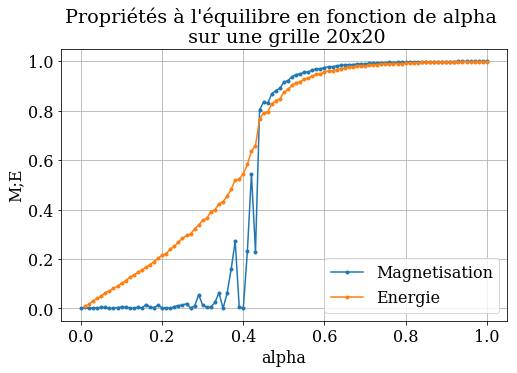

In [28]:
plt.figure(figsize=(8,5));
plt.plot(alphas,abs(Ms), '.-', label='Magnetisation');
plt.plot(alphas[1:],abs(Es[1:]/E_aligned[1:]), '.-', label='Energie');
plt.title("Propriétés à l'équilibre en fonction de alpha \n sur une grille {:d}x{:d}".format(nx,ny));
plt.xlabel('alpha');
plt.ylabel('M;E');
plt.legend(loc=4);
plt.grid()
plt.show()

Notons que nous affichons la valeur absolue de la magnétisation, car celle-ci peut converger vers n'importe laquelle des deux orientations. En ce qui concerne l'énergie, nous la divisons par la valeur d'énergie pour un réseau de spins entièrement alignés et prenons ensuite la valeur absolue.

Remarquons que la magnétisation et l'énergie ne se comportent pas de la même façon. Pour de petites valeurs de $\alpha$, la courbe d'énergie se trouve bien au dessus de la magnétisation, cela s'explique par le fait que plus $\alpha$ est grand, plus les spins voisins on tendance à s'aligner et diminuent l'énergie totale, alors que comme se phénomène d'alignement n'a pas lieu à grande échelle, la magnétisation reste petite. En effet, les contributions des différentes zones alignées se compensent et annulent la magnétisation totale. 

Quand nous partons d'une grille de spins désordonnés, nous observons parfois de vaste régions (de taille comparable à celle du système) de spins alignés dans une direction particulière, différente d'une région à l'autre. Ces régions sont l'analogue dans ce modèles des varitables domaines de Weiss que l'on observe dans un matériau ferromagnétique. Ces domaines de Weiss on pour effet de diminuer fortement la magnétisation pour certaines valeurs de $\alpha$ pourtant au dessus de la valeur critique, alors que comme l'énergie est sommée sur les paires voisines, l'orientation différente des domaines ne se ressent qu'à la frontière entre ceux-ci et les diminutions sont donc beaucoup plus petites.

Sur ce graphique des propriétés à l'équibre en fonction du couplage, nous pouvons observer une nette augmention de la magnétisation totale à partir de $\alpha = 0.4$. Cela nous permet de fournir une première estimation de la valeur critique de $\alpha$, que l'on estime à environ $0.4$.

Pour plus de précision sur cette valeur, nous pouvons définir le couplage critique comme la valeur de $\alpha$ où la courbe de magnétisation passe au dessus de $0.5$. Ce point est arbitraire mais vu la valeur très élevée de la pente près du vrai couplage critique, cela devrait constituer une approximation pas trop mauvaise de ce dernier. L'erreur sur ce résultat est donnée par notre résolution mais il faut ajouter à cela l'erreur commise par supposer que le alpha critique est donné par l'abscisse à laquelle la courbe de magnétisation coupe $y=0.5$. 

In [29]:
for i in range(len(alphas)-1):
    if (abs(Ms[i])<=0.5) & (abs(Ms[i+1])>0.5):
        alpha_c = (alphas[i+1]+alphas[i])/2 
        err_alpha_c = (alphas[i+1]-alphas[i])/2
        break # afin de ne pas détecter les pics dû aux domaines de Weiss non alignés

print("Notre couplage critique vaut {:.3f} $\pm$ {:.3f}".format(alpha_c,err_alpha_c))

Notre couplage critique vaut 0.415 $\pm$ 0.005


Ce résultat est proche de la valeur théorique obtenue par Onsager, qui est:

$$ \alpha = \frac{\ln( 1+\sqrt 2 )}{2} \approx 0.441$$

Gardons évidemment en tête que ce résultat est valable dans la limite où le réseau est de taille infine, le nôtre n'étant consititué que de 20x20 spins.

Cependant, une méthode plus précise existe pour déterminer cette valeur critique. Elle consiste à observer la capacité calorifique en fonction de $\alpha$, le graphique devant présenter un pic à la valeur critique de couplage.

Nous avons relancé une simulation beaucoup plus précise s'étalant sur plusieurs heures de calcul et analysé les résultats dans un **notebook en annexe** ("Calcul_alpha_critique.ipynb").

Nous avons obtenu comme couplage critique pour une grille de $20\times20$ spins la valeur suivante:

$$ \alpha = 0.4336(10) $$

## Domaines de Weiss

De temps à autre, nous observons des cas d'évolution pour lesquels la magnétisation n'atteint pas son maximum (1) alors que le paramètre alpha est supérieur à sa valeur critique. Cela est dû à un aboutissement de l'évolution des spins vers un ensemble de plusieurs régions présentant un alignement des spins différent de l'un à l'autre. Nous appellerons ces régions "domaines de Weiss" par analogie avec le phénomène similaire présent dans les matiériaux ferromagnétiques.

Les domaines de Weiss ne se forment pas à chaque fois que nous faisons tourner le code. Certaines conditions initiales sont plus propices à les créer sans pour autant assurer leur apparition puisque l'évolution dans le temps du sytème est aléatoire, vu la façon dont fonctionne $metropolis\_at\_site$. Il a fallu faire tourner le code quelques fois avant d'observer des domaines de Weiss. 

En **annexe** de ce document se trouve le fichier $Weiss.mp4$ montrant la formation desdits domaines. Ci-dessous, nous représentons l'évolution de la magnétisation et de l'énergie du système au fur et à mesure des itérations. 

<img src="./Weiss.png" alt="Drawing" style="width: 500px" align="center" />

Le fait que la magnétisation moyenne ait une valeur proche de 0 indique qu'environ la moitié des spins a une direction opposée à la partie restante des spins. La vidéo ci-dessus permet bel et bien de distnguer deux zones - de Weiss - d'orientations distinctes de spins. 

Comme nous l'avons mentionné, il ne nous est pas possible de vous assurer de retomber sur un résultat identique à celui présenté ci-dessus; par rigueur, nous inscrivons tout de même le code qui nous a permis d'obtenir ce que nous venons d'expliquer.

In [30]:
def ising_model_metropolis(sp, NMC, nx, ny, alpha):
    """ Creates a sequence of states for the Ising model using
    the Metropolis algorithm
   
    Parameters:
    ----------
    sp   : initial lattice state
    nx   : int
        Discretization points in x
    ny   : int
        Discretization points in y
    NMC  : int
        Number of states to create
    alpha  : real
        coupling constant J/(kb*T)
    Returns:
    -------
    states: sequence of states
    """
    states = np.empty([NMC+1,nx,ny])
    states[0] = sp.copy()
    
    for i in range(1,NMC+1):
        for j in range(0,nx*ny):
            ix=np.random.randint(0,nx)
            iy=np.random.randint(0,ny)
            metropolis_at_site(sp,alpha,ix,iy)
        states[i]=sp.copy()
    return states

In [31]:
NMC = 100
step = 1
nx = 20 
ny = 20
alpha = 0.85

sp_Weiss0 = initial_state_random(nx,ny)
sp_Weiss = sp_Weiss0.copy()

E_aligned = moy_ener(np.ones((nx,ny)),alpha)
states_Weiss = ising_model_metropolis(sp_Weiss, NMC, nx, ny, alpha)

sp_Weiss = sp_Weiss0.copy()
[M,E] = M_with_time_for_alpha(sp_Weiss,nx,ny,NMC,step,alpha)

In [32]:
fig = plt.figure(figsize=(6,6))
img1 = plt.imshow(states_Weiss[0],interpolation="none",origin='lower',\
                     vmin=-1, vmax=1)

# Animate
def animate(i):
    img1.set_array(states_Weiss[i])

anim = animation.FuncAnimation(fig, animate, frames=NMC, interval=200)
plt.close()
HTML(anim.to_html5_video())

In [33]:
# anim.save("Weiss2.mp4") Enlever le "#" créera une vidéo nommée "Weiss2.mp4"

Ci-dessous, le résultat de l'évolution des propriétés physiques pour cette grille.

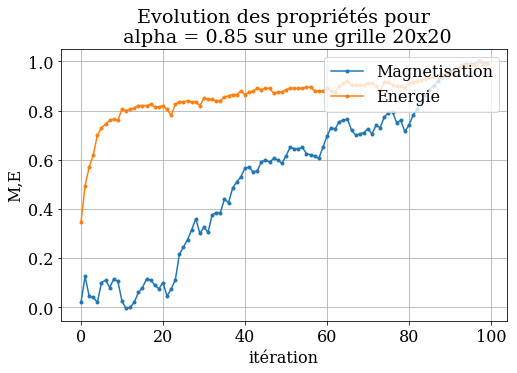

In [34]:
plt.figure(figsize=(8,5));
plt.plot(np.arange(0,len(M)*step,step),M, '.-', label='Magnetisation');
plt.plot(np.arange(0,len(E)*step,step),abs(E/E_aligned), '.-', label='Energie')
plt.title("Evolution des propriétés pour\n alpha = {:.2f} sur une grille {:d}x{:d}".format(alpha,nx,ny));
plt.xlabel('itération');
plt.ylabel('M,E');
plt.legend(loc=1);
plt.grid()
plt.show()

Le lecteur est invité à relancer plusieurs fois ces dernières cellules si aucun domaine de Weiss n'est observé.

## Question 2

Faisons à présent varier les conditions aux bords et les conditions initiales grâce aux fonctions $edges\_conditions$, $square\_center$ et $init\_chessboard$. Nous modifions en prime quelque peu les fonctions $metropolis\_at\_site$, $M\_with\_time\_for\_alpha$ et $M\_equilibrium\_for\_alphas$ afin d'intégrer dans notre code les conditions aux bords.

In [35]:
def edges_conditions(sp,borders):
    """Fixes the boundary conditions
    
    Parameters:
    ----------
    sp   : array
        Matrix of spins
    borders   : array
        Array of 4 numbers to fix the boundary conditions. The first indice is for the top line, the second one for 
        the left row and so on.
    """
    sp[0,:] = borders[0]*np.ones([1,ny])
    sp[:,[0]] = borders[1]*np.ones([nx,1])
    sp[-1,:] = borders[2]*np.ones([1,ny])
    sp[:,[-1]] = borders[3]*np.ones([nx,1])
    
    return sp

In [36]:
def square_center(sp,a):
    """Fixes the boundary conditions in a square at the center of the frames
    
    Parameters:
    ----------
    sp   : array
        Matrix of spins
    a   : int
        Allows to choose the value of the spins inside the square
    """
    nx = np.shape(sp)[0]
    ny = np.shape(sp)[1]
    
    sp[int(nx/4):int(3*nx/4),int(ny/4):int(3*ny/4)] = a*np.ones([int(nx/2),int(ny/2)])
    
    return sp

In [37]:
def init_chessboard(sp):
    """Imposes that one out of two compartments in the initial frame is +1 and the other one -1, as a chessboard
    
    Parameters:
    ----------
    sp   : array
        The matrix "sp" must be initialized before using this function
    """
    nx = np.shape(sp)[0]
    ny = np.shape(sp)[1]
    
    sp = np.ones([nx,ny])
    
    for i in range(nx):
        for j in range(ny):
            if (i+j)%2==1:
                sp[i,j] = -1
                
    return sp

In [38]:
def left_right_edges(sp):
    """Imposes that the left edge's spins equal l and the right ones r 
    
    Parameters:
    ----------
    sp   : array
        The matrix "sp" must be initialized before using this function
    l,r  : int
        Indicate respectively the values of spins on the left and right edges
    """
    nx = np.shape(sp)[0]
    ny = np.shape(sp)[1]
    
    sp[:,0] = np.ones(nx)
    sp[:,-1] = -np.ones(nx)
    
    return sp

In [39]:
we = np.zeros((5,5))
left_right_edges(we)

array([[ 1.,  0.,  0.,  0., -1.],
       [ 1.,  0.,  0.,  0., -1.],
       [ 1.,  0.,  0.,  0., -1.],
       [ 1.,  0.,  0.,  0., -1.],
       [ 1.,  0.,  0.,  0., -1.]])

In [40]:
def metropolis_at_site2(sp,alpha,ix,iy,param,borders,a):
    """ Flips a dipole at site ix, iy when probability condition is met and refix the boundary conditions
   
    Parameters:
    ----------
    sp   : numpy array
        array of spins
    alpha  : real
        coupling constant J/(kb*T)
    ix   : int
        location in x
    iy   : int
        location in y
    param   : int
        Allows to choose the boundary conditions to apply
    borders    : Array
        Allows to choose the fixed boundary conditions on the frames' egdes
    a   : int
        Allows to choose the value of the spins inside the square 
    """
    nx = np.shape(sp)[0]
    ny = np.shape(sp)[1]
    
    sigma=sp[ix,iy]
    energy_before_flip = energy_at_site(sp,alpha,sigma,ix,iy)
    sigma = -sigma
    energy_if_site_flipped = energy_at_site(sp,alpha,sigma,ix,iy)
    
    # Flip the site with Metropolis probability
    # Condition is always satisifed if dE < 0
    if (np.random.random_sample()<np.exp(-(energy_if_site_flipped \
                                               -energy_before_flip))):
        sp[ix,iy]=-sp[ix,iy]
        
    # Fix the boundary conditions
    if param==1:
        sp = edges_conditions(sp,borders)        
    
    elif param==2:
        sp = square_center(sp,a)
    
    elif param==3:
        sp = left_right_edges(sp)
        
    return sp

In [41]:
def M_with_time_for_alpha2(sp,NMC,step,alpha,param,borders,a):
    """ Computes the evolution of the magnetisation and energy with time for a given coupling 
    constant for the Ising model using the Metropolis algorithm
   
    Parameters:
    ----------
    sp   : initial lattice state
    
    NMC  : int
        Number of states to create
    step   : Step between each magnetisation computation
    alpha  : Double
        coupling constant J/(kb*T)
    param   : int
        Allows to choose the boundary conditions to apply
    borders    : Array
        Allow to choose the fixed boundary conditions on the frames' egdes
    a   : int
        Allows to choose the value of the spins inside the square 
        
    Returns:
    -------
    M: magnetisation 
    E: energy
    """
    
    nx = np.shape(sp)[0]
    ny = np.shape(sp)[1]
    
    M = np.empty([int(NMC/step)])
    E = np.empty([int(NMC/step)])
    
    for i in range(int(NMC)):
            
        for j in range(0,nx*ny):
            ix=np.random.randint(0,nx)
            iy=np.random.randint(0,ny)
            metropolis_at_site2(sp,alpha,ix,iy,param,borders,a)
            
        if i%step==0:
            M[int(i/step)] = moy_magn(sp)
            E[int(i/step)] = moy_ener(sp,alpha)
            
    return [M,E]

In [42]:
def M_equilibrium_for_alphas2(sps,NMC,step,alphas,NMC_eq,param,borders,a):
    """ Computes the average magnetisation and energy at equilibrium with different coupling constants for the Ising model using
    the Metropolis algorithm
   
    Parameters:
    ----------
    sps  : Vector containing the initial lattice states
    nx   : int
        Discretization points in x
    ny   : int
        Discretization points in y
    NMC  : int
        Number of states to create
    step   : Step between each magnetisation computation
    alphas : Vector of reals containing the
        coupling constants alpha = J/(kb*T)
    NMC_eq : Number of states to create before reaching the equilibrium
    param   : int
        Allows to choose the boundary conditions to apply
    borders    : Array
        Allow to choose the fixed boundary conditions on the frames' egdes
    a   : int
        Allows to choose the value of the spins inside the square
    
    Returns:
    -------
    Ms: Vector of magnetisations at equilibrium for each alpha in alphas
    Es: Vector of energies at equilibrium for each alpha in alphas
    """
    nx = np.shape(sps[0])[0]
    ny = np.shape(sps[0])[1]
    
    Ms = np.empty([len(alphas)])
    Es = np.empty([len(alphas)])
    
    for i in range(len(alphas)):
        
        print("loop at alpha = {:.2f}".format(alphas[i]))
        spsi = sps[i]
        
        for j in range(NMC_eq):
                
            for k in range(0,nx*ny):
                ix=np.random.randint(0,nx)
                iy=np.random.randint(0,ny)
                metropolis_at_site2(spsi,alphas[i],ix,iy,param,borders,a)
        
        [M_evol,E_evol] = M_with_time_for_alpha2(spsi,NMC-NMC_eq,step,alphas[i],param,borders,a)
        
        Ms[i] = M_evol.sum()/len(M_evol)
        Es[i] = E_evol.sum()/len(E_evol)
    
    return [Ms,Es]

Nous allons, pour différentes conditions aux bords et initiales, trouver approximativement la valeur de $\alpha$ pou laquelle la transition de phase s'opère. Nous traçons pour ce faire les graphiques de la magnétiation et de l'énergie en fonction de la valeur de $\alpha$ pour chaque cas. Nous repérons ensuite la partie du graphique dont la pente est la plus élevée. 

### Pour des spins valant 1 partout sur les bords extérieurs et orientés aléatoirement partout ailleurs

In [43]:
NMC = 200
NMC_eq = 100
step = 1
nx = 20 # petit pour une simple verification
ny = 20
len_alpha = 21
alphas = np.linspace(0,1,len_alpha)

sps = np.empty([len_alpha,nx,ny])

param = 1
borders = [1,1,1,1]
a = 1

for i in range(len_alpha):
    sps[i] = initial_state_random(nx,ny)

E_aligned = moy_ener_vect(np.ones((nx,ny)),alphas)

[Ms,Es] = M_equilibrium_for_alphas2(sps,NMC,step,alphas,NMC_eq,param,borders,a)

loop at alpha = 0.00
loop at alpha = 0.05
loop at alpha = 0.10
loop at alpha = 0.15
loop at alpha = 0.20
loop at alpha = 0.25
loop at alpha = 0.30
loop at alpha = 0.35
loop at alpha = 0.40
loop at alpha = 0.45
loop at alpha = 0.50
loop at alpha = 0.55
loop at alpha = 0.60
loop at alpha = 0.65
loop at alpha = 0.70
loop at alpha = 0.75
loop at alpha = 0.80
loop at alpha = 0.85
loop at alpha = 0.90
loop at alpha = 0.95
loop at alpha = 1.00


Nous avons affiché les valeurs de $\alpha$ afin de donner une idée du temps mis par le code.

Ci-après, nous donnons les graphiques de la magnétisation et de l'énergie (normalisées) en fonction de la valeur de $\alpha$.

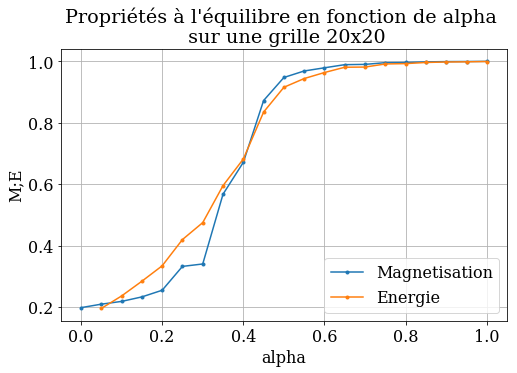

In [44]:
plt.figure(figsize=(8,5));
plt.plot(alphas,abs(Ms), '.-', label='Magnetisation');
plt.plot(alphas[1:],abs(Es[1:]/E_aligned[1:]), '.-', label='Energie');
plt.title("Propriétés à l'équilibre en fonction de alpha \n sur une grille {:d}x{:d}".format(nx,ny));
plt.xlabel('alpha');
plt.ylabel('M;E');
plt.legend(loc=4);
plt.grid()
plt.show()

Nous séletionnons, à l'oeil, la région où il nous semble que les pentes des graphiques de la magnétisation et de l'énergie sont les plus fortes afin de désigner le couplage critique, $\alpha_c$. Ici, $\alpha_c$ vaut environ 0.4. Il est possible que le changement des conditions ait pu légèrement diminuer la valeur du $\alpha_c$, cependant le manque de précision ne nous permet pas de l'affirmer, cela peut très bien être contenu dans les marges d'erreur.

Enfin, nous affichons une des tranches finales pur une certaine valeur de $\alpha$. Cela nous permet d'avoir une idée de ce qu'il s'est passé au sein du système. De plus, nous pouvons vérifier une première fois que les conditions aux bords ne changent pas pour les différentes valeurs de $\alpha$, en modifiant l'indice de la liste $sps$ ci-dessous. Ensuite, nous comprenons qu'il est peu probable, puisque ces conditions aux bords sont maintenues pour chaque valeur de couplage, que celles-ci aient varié durant l'évolution du système pour une valeur de $\alpha$ donnée. Nous affirmons ainsi que les conditions aux bords sont toujours maintenues. 

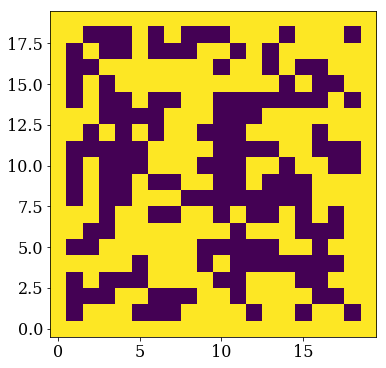

In [45]:
plt.figure(figsize=(6,6))
plt.imshow(sps[3],interpolation="none",origin='lower');

### Pour des spins valant 1 partout sur les bords extérieurs et un échiquier comme condition initiale

In [46]:
NMC = 200
NMC_eq = 100
step = 1
nx = 20 # petit pour une simple verification
ny = 20
len_alpha = 21
alphas = np.linspace(0,1,len_alpha)

sps = np.empty([len_alpha,nx,ny])

param = 1
borders = [1,1,1,1]
a = 1

for i in range(len_alpha):
     sps[i] = init_chessboard(sps[i])
        
E_aligned = moy_ener(np.ones((nx,ny)),alphas)
    
[Ms,Es] = M_equilibrium_for_alphas2(sps,NMC,step,alphas,NMC_eq,param,borders,a)

loop at alpha = 0.00
loop at alpha = 0.05
loop at alpha = 0.10
loop at alpha = 0.15
loop at alpha = 0.20
loop at alpha = 0.25
loop at alpha = 0.30
loop at alpha = 0.35
loop at alpha = 0.40
loop at alpha = 0.45
loop at alpha = 0.50
loop at alpha = 0.55
loop at alpha = 0.60
loop at alpha = 0.65
loop at alpha = 0.70
loop at alpha = 0.75
loop at alpha = 0.80
loop at alpha = 0.85
loop at alpha = 0.90
loop at alpha = 0.95
loop at alpha = 1.00


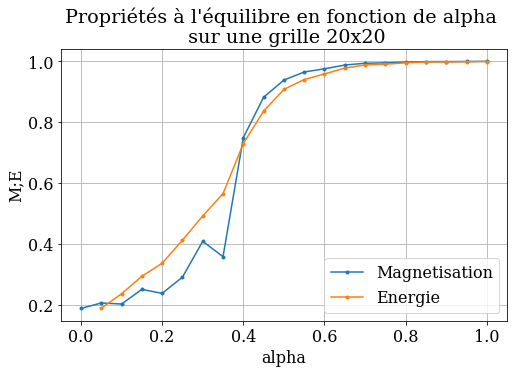

In [47]:
plt.figure(figsize=(8,5));
plt.plot(alphas,abs(Ms), '.-', label='Magnetisation');
plt.plot(alphas[1:],abs(Es[1:]/E_aligned[1:]), '.-', label='Energie');
plt.title("Propriétés à l'équilibre en fonction de alpha \n sur une grille {:d}x{:d}".format(nx,ny));
plt.xlabel('alpha');
plt.ylabel('M;E');
plt.legend(loc=4);
plt.grid()
plt.show()

A nouveau, $\alpha_c$ vaut environ 0.4. 

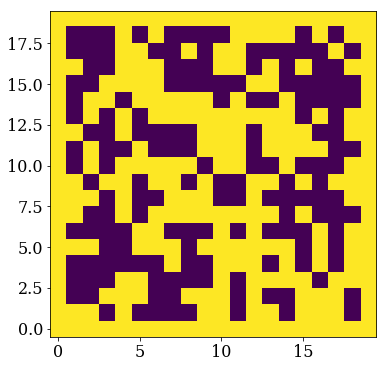

In [48]:
plt.figure(figsize=(6,6))
plt.imshow(sps[0],interpolation="none",origin='lower');

#### Remarques

1) Lorsque nous avons fait tourné la partie de code ci-dessus, nous avons obtenu plusieurs fois un graphique ressemblant à celui présent sur la figure suivante:

<img src="./alpha_09.png" alt="Drawing" style="width: 500px" align="center" />

Nous observons une diminution soudaine de la magnétistion, signe de la présence d'un domaine de Weiss. 

2) L'orientation initiale aléatoire donne un résultat très proche de l'orientation initiale en damier, ce à quoi nous pouvions nous attendre puisqu'elles ne diffèrent en général que de quelques spins.

### Pour des spins valant 1 partout sur les bords extérieurs et tous les autres spins mis à -1 initialement

In [49]:
NMC = 200
NMC_eq = 100
step = 1
nx = 20 
ny = 20
len_alpha = 21
alphas = np.linspace(0,1,len_alpha)

sps = np.empty([len_alpha,nx,ny])

param = 1
borders = [1,1,1,1]
a = 1


for i in range(len_alpha):
     sps[i] = -1*initial_state_aligned(nx,ny)
        
E_aligned = moy_ener(np.ones((nx,ny)),alphas)
    
[Ms,Es] = M_equilibrium_for_alphas2(sps,NMC,step,alphas,NMC_eq,param,borders,a)

loop at alpha = 0.00
loop at alpha = 0.05
loop at alpha = 0.10
loop at alpha = 0.15
loop at alpha = 0.20
loop at alpha = 0.25
loop at alpha = 0.30
loop at alpha = 0.35
loop at alpha = 0.40
loop at alpha = 0.45
loop at alpha = 0.50
loop at alpha = 0.55
loop at alpha = 0.60
loop at alpha = 0.65
loop at alpha = 0.70
loop at alpha = 0.75
loop at alpha = 0.80
loop at alpha = 0.85
loop at alpha = 0.90
loop at alpha = 0.95
loop at alpha = 1.00


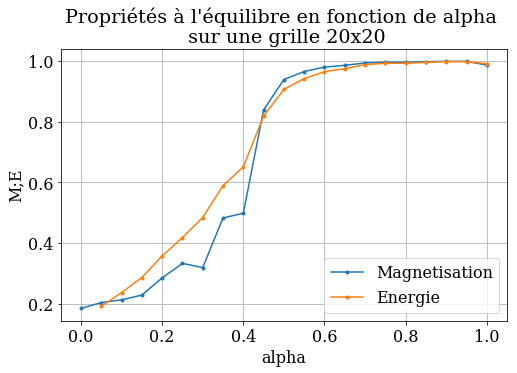

In [50]:
plt.figure(figsize=(8,5));
plt.plot(alphas,abs(Ms), '.-', label='Magnetisation');
plt.plot(alphas[1:],abs(Es[1:]/E_aligned[1:]), '.-', label='Energie');
plt.title("Propriétés à l'équilibre en fonction de alpha \n sur une grille {:d}x{:d}".format(nx,ny));
plt.xlabel('alpha');
plt.ylabel('M;E');
plt.legend(loc=4);
plt.grid()
plt.show()

$\alpha_c$ se trouve encore une fois aux alentours de 0.4.

### Pour les spins du centre de la tranche valant tous 1 et les autres valant -1

In [51]:
NMC = 600
NMC_eq = 500
step = 1
nx = 20 
ny = 20
len_alpha = 21
alphas = np.linspace(0,1,len_alpha)

sps = np.empty([len_alpha,nx,ny])

param = 2
borders = [1,1,1,1]
a = 1

for i in range(len_alpha):
     sps[i] = -initial_state_aligned(nx,ny)
        
E_aligned = moy_ener(np.ones((nx,ny)),alphas)
    
[Ms,Es] = M_equilibrium_for_alphas2(sps,NMC,step,alphas,NMC_eq,param,borders,a)

loop at alpha = 0.00
loop at alpha = 0.05
loop at alpha = 0.10
loop at alpha = 0.15
loop at alpha = 0.20
loop at alpha = 0.25
loop at alpha = 0.30
loop at alpha = 0.35
loop at alpha = 0.40
loop at alpha = 0.45
loop at alpha = 0.50
loop at alpha = 0.55
loop at alpha = 0.60
loop at alpha = 0.65
loop at alpha = 0.70
loop at alpha = 0.75
loop at alpha = 0.80
loop at alpha = 0.85
loop at alpha = 0.90
loop at alpha = 0.95
loop at alpha = 1.00


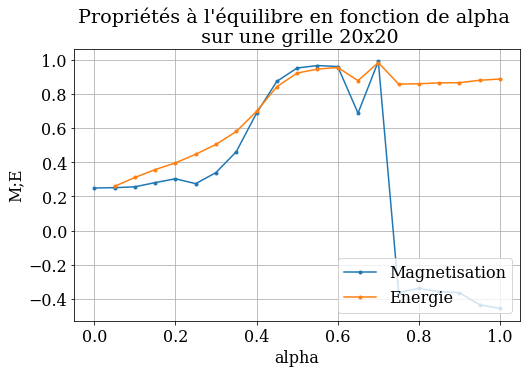

In [52]:
plt.figure(figsize=(8,5));
plt.plot(alphas,Ms, '.-', label='Magnetisation');
plt.plot(alphas[1:],abs(Es[1:]/E_aligned[1:]), '.-', label='Energie');
plt.title("Propriétés à l'équilibre en fonction de alpha \n sur une grille {:d}x{:d}".format(nx,ny));
plt.xlabel('alpha');
plt.ylabel('M;E');
plt.legend(loc=4);
plt.grid()
plt.show()

Une différence se marque par rapport aux situations précédentes. Ce graphique révèle que, pour de telles conditions aux bords et initiales, le système n'a pas pu atteindre l'équilibre (tous les spins alignés) en $NMC\_eq$ itérations pour des valeurs de $\alpha$ supérieures à 0.6. Notons qu'il est probable que les 500 itérations choisies ne suffisent pas atteindre l'équilibre même pour $\alpha = 0.6$, l'évolution du système étant aléatoire. En d'autres termes, si nous augmentons largement $NMC\_eq$, nous retrouverons un graphique dont l'allure est semblable à ceux des situations antérieures: un plateau après la transition de phase. Notons d'ailleurs que celle-ci se situe toujours aux envirions de $\alpha = 0.4$. Ceci nous permet de constater une fois de plus que les conditions aux bords et initiales ont une influence sur la dynamique du système. 

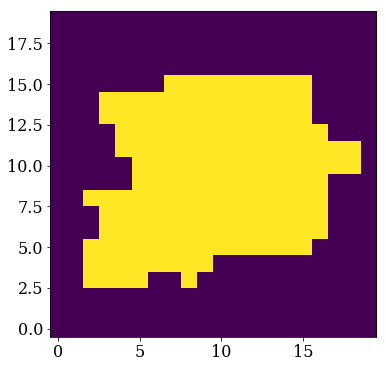

In [53]:
plt.figure(figsize=(6,6))
plt.imshow(sps[16],interpolation="none",origin='lower');

Le code ci-après nous a permis de comprendre que l'équilibre n'était bien souvent pas atteint pour des valeurs de $\alpha > 0.6$. 

In [54]:
def ising_model_metropolis2(sp, NMC, nx, ny, alpha,param,borders,a):
    """ Creates a sequence of states for the Ising model using
    the Metropolis algorithm
   
    Parameters:
    ----------
    sp   : initial lattice state
    nx   : int
        Discretization points in x
    ny   : int
        Discretization points in y
    NMC  : int
        Number of states to create
    alpha  : real
        coupling constant J/(kb*T)
    Returns:
    -------
    states: sequence of states
    """
    states = np.empty([NMC+1,nx,ny])
    states[0] = sp.copy()
    
    for i in range(1,NMC+1):
        for j in range(0,nx*ny):
            ix=np.random.randint(0,nx)
            iy=np.random.randint(0,ny)
            metropolis_at_site2(sp,alpha,ix,iy,param,borders,a)
        states[i]=sp.copy()
    return states

Nous avons fait varier le nombre d'itérations $NMC$ pour une certaine valeur de $\alpha$. Nous laissons ici un exemple, permettant de montrer que même 1000 itérations sont rarement suffisantes pour atteindre l'équilibre thermodynamique pour $\alpha = 0.8$. 

In [55]:
NMC = 2000
step = 10
nx = 20 
ny = 20
alpha = 0.8
a = 1
borders = [1,1,1,1]
param = 2

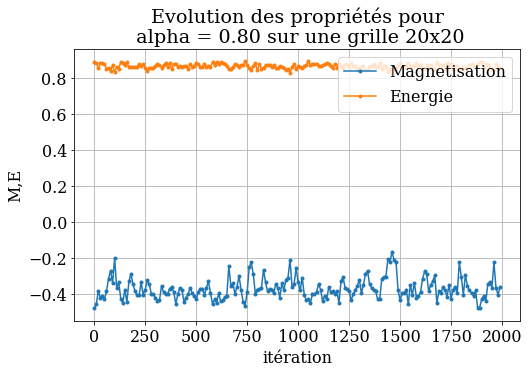

In [56]:
sp = -initial_state_aligned(nx,ny)
sp = square_center(sp,1)
E_aligned = moy_ener(np.ones((nx,ny)),alpha)
[M,E] = M_with_time_for_alpha2(sp,NMC,step,alpha,param,borders,a)

plt.figure(figsize=(8,5));
plt.plot(np.arange(0,len(M)*step,step),M, '.-', label='Magnetisation');
plt.plot(np.arange(0,len(E)*step,step),abs(E/E_aligned), '.-', label='Energie')
plt.title("Evolution des propriétés pour\n alpha = {:.2f} sur une grille {:d}x{:d}".format(alpha,nx,ny));
plt.xlabel('itération');
plt.ylabel('M,E');
#plt.xlim([0,100])
plt.legend(loc=1);
plt.grid()
plt.show()

In [57]:
start = time.time()
sp = -initial_state_aligned(nx,ny)
sp = square_center(sp,1)

E_aligned = moy_ener(np.ones((nx,ny)),alpha)
states = ising_model_metropolis2(sp, NMC, nx, ny, alpha,param,borders,a)

fig = plt.figure(figsize=(6,6))
img1 = plt.imshow(states[0],interpolation="none",origin='lower',\
                     vmin=-1, vmax=1)

# Animate
def animate(i):
    img1.set_array(states[i*10])

anim = animation.FuncAnimation(fig, animate, frames=int(NMC/10), interval=100)
plt.close()
HTML(anim.to_html5_video())

In [58]:
print(time.time()-start)

27.14535164833069


### Pour des spins valant 1 sur le côté gauche, -1 sur le côté droit et aléatoires pour les autres

In [59]:
NMC = 500
step = 1
nx = 20 
ny = 20
alpha = 0.7
a = 1
borders = [1,1,1,1]
param = 3

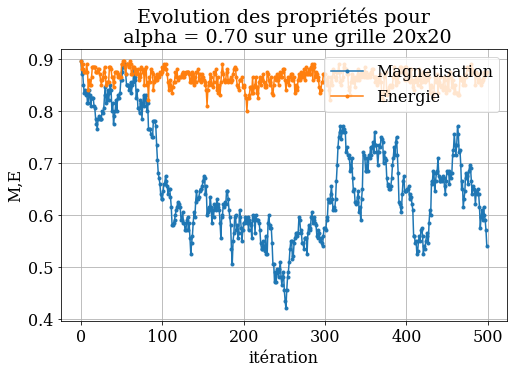

In [60]:
sp0 = initial_state_random(nx,ny)
sp0 = left_right_edges(sp)

sp = sp0.copy()

E_aligned = moy_ener(np.ones((nx,ny)),alpha)
[M,E] = M_with_time_for_alpha2(sp,NMC,step,alpha,param,borders,a)

plt.figure(figsize=(8,5));
plt.plot(np.arange(0,len(M)*step,step),M, '.-', label='Magnetisation');
plt.plot(np.arange(0,len(E)*step,step),abs(E/E_aligned), '.-', label='Energie')
plt.title("Evolution des propriétés pour\n alpha = {:.2f} sur une grille {:d}x{:d}".format(alpha,nx,ny));
plt.xlabel('itération');
plt.ylabel('M,E');
plt.legend(loc=1);
plt.grid()
plt.show()

In [61]:
start = time.time()
E_aligned = moy_ener(np.ones((nx,ny)),alpha)
sp = sp0.copy()

states = ising_model_metropolis2(sp, NMC, nx, ny, alpha,param,borders,a)

fig = plt.figure(figsize=(6,6))
img1 = plt.imshow(states[0],interpolation="none",origin='lower',\
                     vmin=-1, vmax=1)

# Animate
def animate(i):
    img1.set_array(states[i*5])

anim = animation.FuncAnimation(fig, animate, frames=int(NMC/5), interval=100)
plt.close()
#plt.colorbar();
HTML(anim.to_html5_video())

In [62]:
print(time.time()-start)

9.23061728477478


Dans cette vidéo, nous remarquons deux zones presque unicolores (à quelques fluctuations statistiques près) où les spins sont majoritairement parallèles, séparées par une région dont la magnétisation fluctue sans cesse. Nous pouvons visualiser cette frontière comme un état d'équilibre, au même titre que les deux zones unicolores. En effet, la magnétisation totale et l'énergie potentielle de la frontière sont peu influencées par l'inversion d'un de ses spins. Bien entendu, cette équilibre local peut rapidement disparaître selon l'importance des fluctuations thermiques.  

Nous pouvons à nouveau tracer les graphiques de la magnétisation et de l'énergie en fonction de la valeur de $\alpha$ et trouver $\alpha_c$.  

In [63]:
NMC = 200
NMC_eq = 100
step = 1
nx = 20 
ny = 20
len_alpha = 21
alphas = np.linspace(0,1,len_alpha)

sps = np.empty([len_alpha,nx,ny])

sp_0 = initial_state_random(nx,ny)
sp_0 = left_right_edges(sp_0)

param = 3
borders = [1,1,1,1]
a = 1

for i in range(len_alpha):
     sps[i] = sp_0
        
E_aligned = moy_ener(initial_state_aligned(nx,ny),alphas)
    
[Ms,Es] = M_equilibrium_for_alphas2(sps,NMC,step,alphas,NMC_eq,param,borders,a)

loop at alpha = 0.00
loop at alpha = 0.05
loop at alpha = 0.10
loop at alpha = 0.15
loop at alpha = 0.20
loop at alpha = 0.25
loop at alpha = 0.30
loop at alpha = 0.35
loop at alpha = 0.40
loop at alpha = 0.45
loop at alpha = 0.50
loop at alpha = 0.55
loop at alpha = 0.60
loop at alpha = 0.65
loop at alpha = 0.70
loop at alpha = 0.75
loop at alpha = 0.80
loop at alpha = 0.85
loop at alpha = 0.90
loop at alpha = 0.95
loop at alpha = 1.00


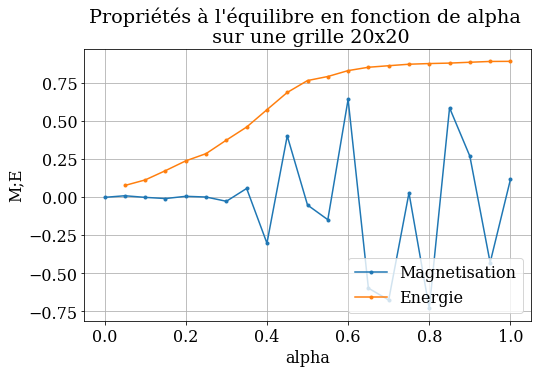

In [64]:
plt.figure(figsize=(8,5));
plt.plot(alphas,Ms, '.-', label='Magnetisation');
plt.plot(alphas[1:],abs(Es[1:]/E_aligned[1:]), '.-', label='Energie');
plt.title("Propriétés à l'équilibre en fonction de alpha \n sur une grille {:d}x{:d}".format(nx,ny));
plt.xlabel('alpha');
plt.ylabel('M;E');
plt.legend(loc=4);
plt.grid()
plt.show()

Notons que la magnétisation n'est plus un judicieux indicateur de la prédominance de l'agitation thermique sur les effets magnétiques, ou l'iverse. En effet, bien que les spins soient alignés par zone - comme des domaines de Weiss en réalité - et que les effets magnétiques permettent de garder un alignement notable au sein de ses zones, le fait que la magnétisation totale soit nulle peut laisser entendre que les effets thermiques prennent l'avantage sur les effets magnétiques. Bien entendu, cette discussion se tient pour des valeurs de $\alpha$ supérieures à $\alpha_c$. Nous pouvoir voir que pour $\alpha < \alpha_c$, l'agitation thermique est dominante. Pour ces raisons, nous n'utilisons plus la pente de la magnétisation pour localiser $\alpha_c$, uniquement celle de l'énergie. Nous pourrions évidemment obtenir $\alpha_c$ à partir de la capacité calorifique. Nous observons que $\alpha_c$ vaut environ 0.4.

# Conclusion

Dans la première partie de ce travail, nous avons cherché des moyens alternatifs de créer des variables distribuées selon une loi exponentielle et selon une gaussienne. Ceux-ci ont donné des résultats concluants.

La deuxième partie a été consacrée à la simulation de processus stochastique en 1D. Deux processus ont été étudiés: 
- une marche aléatoire avec dérive: $\quad dx = cdt + \sqrt{2\alpha dt}\cal{N(0,1)}$
- une marche aléatoire avec friction: $\quad dx = -\gamma xdt + \sqrt{2\alpha dt}\cal{N(0,1)}$

Une équation différentielle pour cette densité a été trouvée dans le premier cas et dans les deux cas, nous avons trouvé une solution analytique décrivant l'évolution de la densité de probabilité de présence avec le temps en partant d'une distribution gausienne initiale de paramètres $(\sigma,\mu)$. Celles-ci se sont avéré être des gausiennes:

- dérive: $ \quad \rho(x,t)=\frac{1}{\sqrt{2\pi\sigma_t^2}}e^{-\frac{(x-\mu)^2}{2\sigma_t^2}} + ct \quad $ avec $\quad\sigma^2_t = 2\alpha t + \sigma^2$
- friction: $\quad \rho(x,t) = \frac{1}{\sqrt{2\pi\,\sigma_t^2}}e^{-\frac{(x-\mu_t)^2}{2\sigma_t^2}}\ \qquad$ avec $\quad \sigma_t^2 = \sigma^2 e^{-2\gamma t} + (1-e^{-2\gamma t}) \frac \alpha\gamma \quad$ et $ \quad\mu_t = \mu\, e^{-\gamma t} $


La dernière partie, la plus longue, concernait le modèle d'Ising. Elle se divise en plusieurs points.

Nous avons d'abord dû tester l'algorithme de Métropolis. Nous avons constaté que les "ratios de spins ups sur spins downs" convergeaient bien vers $e^{-\Delta E}$ à chaque fois. 

Ensuite, nous avons simulé l'évolution de plusieurs grilles correspondant à différentes valeurs du couplage $\alpha$. Nous avons pour chaque grille calculeé la magnétisation moyenne. La magnétisation nous a permis de voir dans quel intervalle se situait la transition "ferromagnétique - non ferromagnétique" du système. Nous nous en sommes servi pour estimer le couplage critique du système. Le calcul précis de cette valeur a été réalisé dans un notebook annexe en utilisant le graphique de la capacité calorifique en fonction de $\alpha$. Nous avons obtenu le couplage critique ci-dessous pour une grille de taille 20x20:

$$\alpha_c = 0.4336(10)$$

Comme demandé, nous avons fait varier les conditions aux bords et initiales et constaté que celles-ci se révélaient parfois détermiantes dans l'évolution du système. Comme nous l'avons montré, des domaines de Weiss ont une probabilité plus grande d'apparaître lorsque les spins de départ sont orientés aléatoirement ou en échiquier et pour $\alpha>\alpha_c$. Par ailleurs, bien que fixer à une même valeur les spins sur les bords extérieurs n'ait pas influencé de façon significative l'évolution de la magnétisation, imposer que les spins valent +1 sur un des bords et -1 sur l'arête opposée n'a pas eu le même effet. Dans le premier cas, une orientation identique sur l'entierté de la tranche s'installait, à quelques fluctuations statistiques près et donc la magnétisation était maximal en valeur absolue, tandis que dans le deuxième cas, deux zones aux directions de spins opposées prennaient place et cohabitaient autour d'une zone d'équilibre le long d'une des parallèles aux médiatrices de la tranche carrée et donc une magnétisation oscillant autour de 0. Enfin, quelles que soient les conditions initiales et aux bords, la valeur du couplage critique ne varie pas significativement (voire pas du tout, une précision plus grande tendrait à rapprocher encore plus les valeurs de $\alpha_c$ obtenues). 

En dernier lieu, nous nous sommes intéressé à l'évolution du $\alpha$ critique en augmentant la taille de la grille. Nous avons donc réalisé plusieurs simulations sur différentes taille de grilles dans un fichier annexe, dont les résultats sont affichées ci-dessous. Malheureusement, nous n'avons pas pu constater une convergence vers le résultat théorique pour une grille infinie. 

| N | alpha |
|---|-------|
| 40 | 0.4374(2) |
| 60 | 0.4382(6) |
| 80 | 0.4379(10) |

In [65]:
print("Temps d'exécution de ce notebook: {:.3f} secondes".format( time.time()-start_notebook))

Temps d'exécution de ce notebook: 718.611 secondes
